## Часть 1
Напишите скрипт, который скачивает все данные прошедших губернаторских выборов для всех избирательных участков. 

Входная точка [по ссылке](http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 20 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избирательный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

#### /* ТИК = tec (territorial election committee)
#### Цифровые избирательные участки = dec (digital election committee)
#### УИК = lec (local election committee) */

In [1]:
import pandas as pd
df = pd.read_csv('data.csv')

### Явка

In [2]:
sum_df = df.groupby('ec').sum(numeric_only=True)
turnout_series = ((sum_df['local_ballots'] + sum_df['distant_ballots']) / 
                  sum_df['total_voters'] * 100).sort_values(ascending=False)

turnout_series

ec
dec      75.140187
tec18    51.531228
tec15    40.013072
tec13    39.672610
tec19    37.812382
tec8     36.040981
tec20    33.780554
tec9     33.521975
tec22    32.486297
tec30    32.102011
tec2     31.787913
tec1     31.483272
tec29    30.770507
tec10    30.517413
tec4     30.431840
tec7     29.254120
tec21    29.138204
tec25    29.020921
tec17    28.440004
tec23    28.193842
tec16    28.191436
tec14    27.522452
tec28    27.224589
tec11    26.877083
tec5     26.753819
tec24    26.653968
tec3     26.620459
tec12    26.410227
tec26    26.264800
tec6     25.008379
tec27    24.792315
dtype: float64

### Избирательный участок с наибольшим результатом для Тихоновой Надежды Геннадьевны

In [3]:
df_turnout_100 = df[df['local_ballots'] + df['distant_ballots'] > 100]
df.loc[df_turnout_100['tikhonova_share'].idxmax()]

ec                       tec17
lec                       2283
total_voters              2531
total_ballots             2000
local_ballots              641
distant_ballots              3
unused_ballots            1356
in_mobile_boxes              3
in_stationary_boxes        641
spoiled_ballots              6
valid_ballots              638
lost_ballots                 0
unaccounted_ballots          0
amosov                     117
beglov                     215
tikhonova                  306
amosov_share           18.1677
beglov_share           33.3851
tikhonova_share        47.5155
turnout(%)             25.4445
Name: 1094, dtype: object

### ТИК с максимальным разбросом по явке на УИКах

In [4]:
df_scatter = df.iloc[list(df.groupby('ec')['turnout(%)'].idxmax())].set_index('ec')['turnout(%)'] - \
                df.iloc[list(df.groupby('ec')['turnout(%)'].idxmin())].set_index('ec')['turnout(%)']

df_scatter.idxmax()

'tec17'

### Дисперсия по явке для ТИК

In [5]:
df.groupby('ec')['turnout(%)'].std().sort_values()

ec
tec25     3.029272
tec6      4.545741
tec14     5.543703
tec12     5.763336
tec7      8.432388
tec10     8.607301
tec3      8.610396
tec16    10.652375
tec9     10.905473
tec5     11.688594
tec20    13.174654
tec1     13.899090
tec19    14.307206
tec27    14.364214
tec26    14.827287
tec4     14.926802
tec18    15.188345
tec11    15.474099
tec29    15.632908
tec8     16.119666
tec24    16.466036
tec21    17.612285
tec17    18.147185
tec28    19.800772
tec13    19.836722
tec15    20.398333
tec22    21.214221
tec2     21.451792
tec30    22.820543
tec23    24.221904
dec            NaN
Name: turnout(%), dtype: float64

### Таблица

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

df_table = pd.DataFrame()
df_table = df[['amosov_share', 'ec']].round(0).groupby('amosov_share').count().rename(columns={'ec': 'amosov'})
df_beglov = df[['beglov_share', 'ec']].round(0).groupby('beglov_share').count().rename(columns={'ec': 'beglov'})
df_tikhonova = df[['tikhonova_share', 'ec']].round(0).groupby('tikhonova_share').count().rename(columns={'ec': 'tikhonova'})
df_table.index = df_table.index.rename('share')
df_beglov.index = df_beglov.index.rename('share')
df_tikhonova.index = df_tikhonova.index.rename('share')
df_table = pd.merge(df_table, df_beglov, how='outer', on='share')
df_table = pd.merge(df_table, df_tikhonova, how='outer', on='share')
df_table.fillna(0).transpose()

share,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,98.0,37.0
amosov,1.0,6.0,6.0,2.0,13.0,18.0,25.0,35.0,48.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
beglov,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,6.0,7.0,2.0,1.0,3.0,2.0,1.0,2.0,0.0
tikhonova,2.0,4.0,5.0,11.0,9.0,15.0,21.0,22.0,35.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Визуализация

### По УИК:

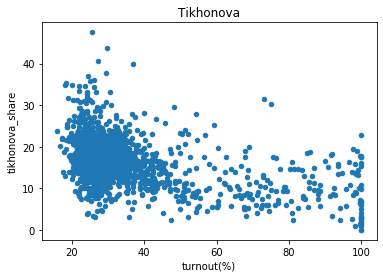

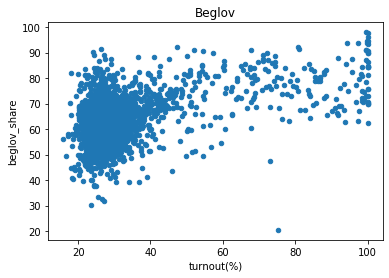

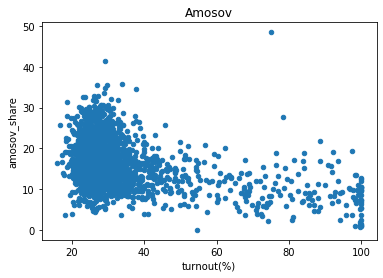

In [7]:
%matplotlib inline

df[['turnout(%)', 'tikhonova_share']].plot(kind='scatter', x='turnout(%)', y='tikhonova_share', title='Tikhonova')
df[['turnout(%)', 'beglov_share']].plot(kind='scatter', x='turnout(%)', y='beglov_share', title='Beglov')
df[['turnout(%)', 'amosov_share']].plot(kind='scatter', x='turnout(%)', y='amosov_share', title='Amosov')

### По ТИК:

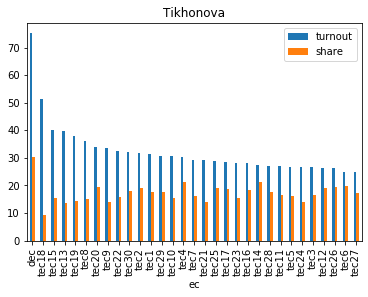

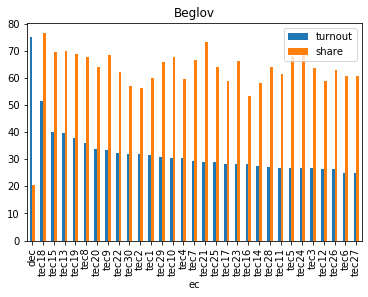

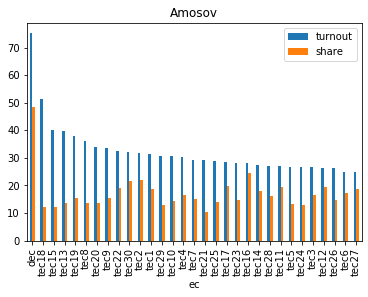

In [8]:
sum_df = df.groupby('ec').sum(numeric_only=True)
plot_df = pd.DataFrame()
plot_df['turnout'] = turnout_series
plot_df['share'] = sum_df['tikhonova'] / (sum_df['valid_ballots'] + sum_df['spoiled_ballots']) * 100
plot_df.plot(kind='bar', title='Tikhonova')
plot_df['share'] = sum_df['beglov'] / (sum_df['valid_ballots'] + sum_df['spoiled_ballots']) * 100
plot_df.plot(kind='bar', title='Beglov')
plot_df['share'] = sum_df['amosov'] / (sum_df['valid_ballots'] + sum_df['spoiled_ballots']) * 100
plot_df.plot(kind='bar', title='Amosov')